In [6]:
import optionsdata as od
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from joblib import Parallel, delayed
import matplotlib.pyplot as plt



In [ ]:
failed = await od.fetch_options(["ZEB"], datetime(2024, 1, 1).date(), datetime(2025, 2, 18).date())
print(failed)

In [ ]:
df = pd.read_parquet('data/2024_TRI.parquet')
df[df["volume"] > 0]

In [15]:
bmo = pd.read_parquet('data/2024_BMO.parquet')
bn = pd.read_parquet('data/2024_BN.parquet')
bns = pd.read_parquet('data/2024_BNS.parquet')
cp = pd.read_parquet('data/2024_CP.parquet')
enb = pd.read_parquet('data/2024_ENB.parquet')
ry = pd.read_parquet('data/2024_RY.parquet')
shop = pd.read_parquet('data/2024_SHOP.parquet')
td = pd.read_parquet('data/2024_TD.parquet')
tri = pd.read_parquet('data/2024_TRI.parquet')
xiu = pd.read_parquet('data/2024_XIU.parquet')
zeb = pd.read_parquet('data/2024_ZEB.parquet')

In [ ]:
dfs = [bmo, bn, bns, cp, enb, ry, shop, td, tri, xiu, zeb]
merged = pd.concat(dfs)
merged

In [4]:
df = pd.read_parquet('data/2024_ALL.parquet')

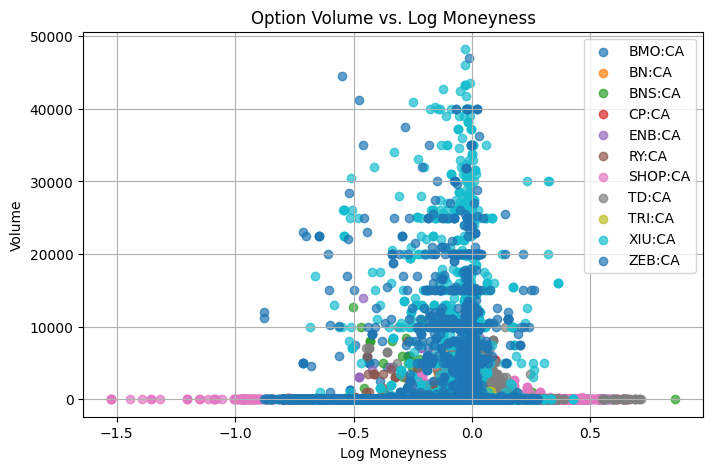

In [4]:
# Sample DataFrame structure
# df should have columns: 'symbol', 'stock_price', 'strike_price', 'volume'

def plot_option_volume(df, stock_symbols):
    plt.figure(figsize=(8, 5))

    for symbol in stock_symbols:
        stock_data = df[df['underlying_symbol'] == symbol].copy()

        # Compute log moneyness
        stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

        # Scatter plot for each stock symbol
        plt.scatter(stock_data['log_moneyness'], stock_data['volume'], alpha=0.7, label=symbol)

    plt.xlabel("Log Moneyness")
    plt.ylabel("Volume")
    plt.title("Option Volume vs. Log Moneyness")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_option_volume(df[(df["volume"] > 0) & (df["volume"] < 50000)], df["underlying_symbol"].unique())


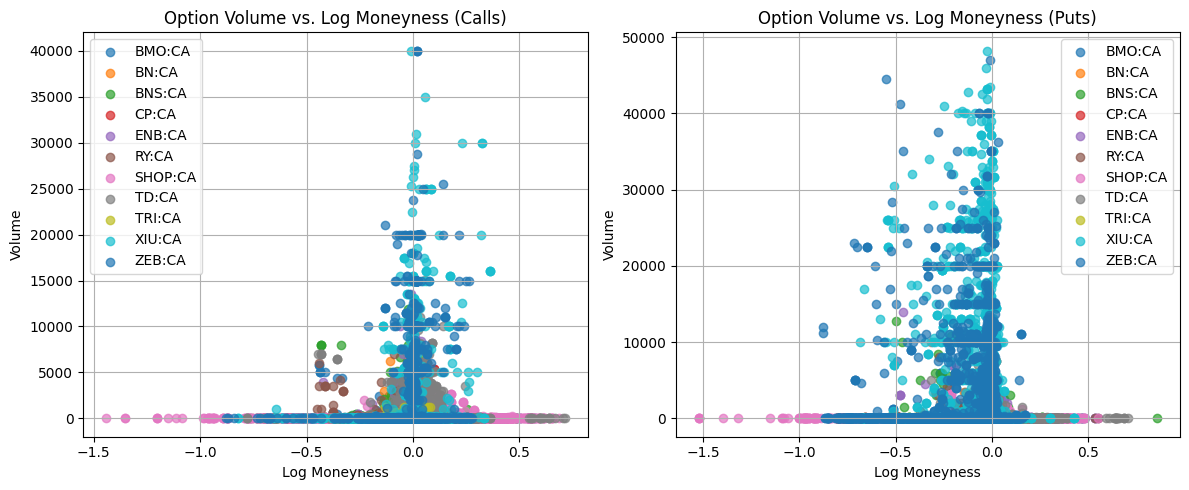

In [5]:
# Sample DataFrame structure
# df should have columns: 'underlying_symbol', 'underlying_price', 'strike', 'volume', 'option_type'

def plot_call_put_volume(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Compute log moneyness
            stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

            # Scatter plot for each stock symbol
            plt.scatter(stock_data['log_moneyness'], stock_data['volume'], alpha=0.7, label=symbol)

        plt.xlabel("Log Moneyness")
        plt.ylabel("Volume")
        plt.title(f"Option Volume vs. Log Moneyness ({title})")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_call_put_volume(df[(df["volume"] > 0) & (df["volume"] < 50000)], df["underlying_symbol"].unique())


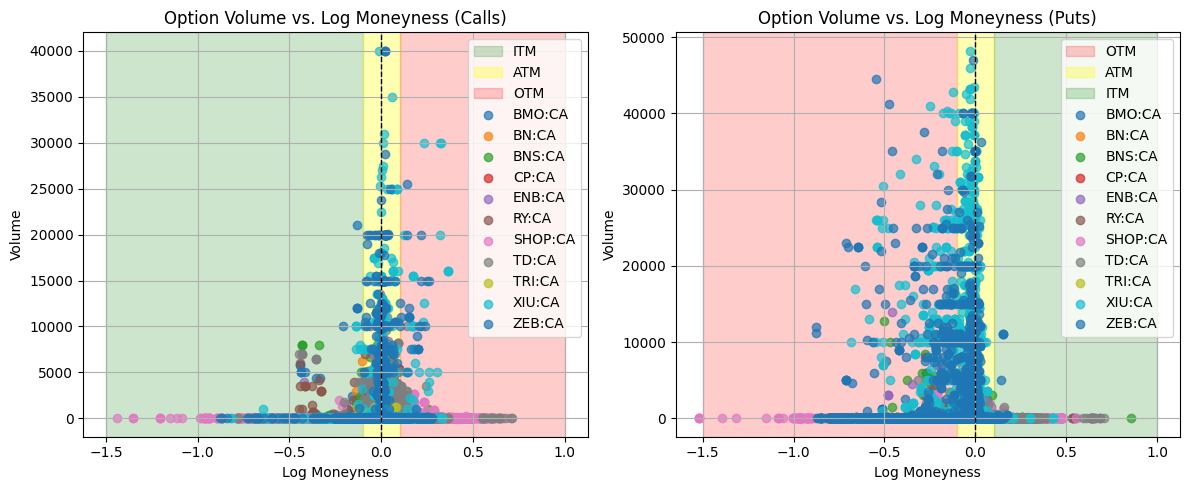

In [6]:
# Sample DataFrame structure
# df should have columns: 'underlying_symbol', 'underlying_price', 'strike', 'volume', 'option_type'

def plot_option_volume(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        if subplot_index == 1:
            # Background shading (ensure this comes before the scatter plot)
            plt.axvspan(-1.5, -0.1, color='green', alpha=0.2, label="ITM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='red', alpha=0.2, label="OTM")  # OTM region
        else:
            plt.axvspan(-1.5, -0.1, color='red', alpha=0.2, label="OTM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='green', alpha=0.2, label="ITM")  # OTM region

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Compute log moneyness
            stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

            # Scatter plot for each stock symbol
            plt.scatter(stock_data['log_moneyness'], stock_data['volume'], alpha=0.7, label=symbol)

        plt.xlabel("Log Moneyness")
        plt.ylabel("Volume")
        plt.title(f"Option Volume vs. Log Moneyness ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Vertical line at ATM
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_volume(df[(df["volume"] > 0) & (df["volume"] < 50000)], df["underlying_symbol"].unique())


In [ ]:
# Black-Scholes formula for call option pricing
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes call option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Black-Scholes formula for put option pricing
def black_scholes_put(S, K, T, r, sigma):
    """Calculate the Black-Scholes put option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Function to calculate the implied volatility for a call or put option
def implied_volatility(market_price, S, K, T, r, option_type='call'):
    """Calculate implied volatility using Brent's method."""
    # Define the objective function for call or put
    if option_type == 'call':
        def objective(sigma):
            return black_scholes_call(S, K, T, r, sigma) - market_price
    elif option_type == 'put':
        def objective(sigma):
            return black_scholes_put(S, K, T, r, sigma) - market_price
    else:
        raise ValueError("option_type must be either 'call' or 'put'")

    # Use Brent's method to find the root, expand bounds
    try:
        implied_vol = brentq(objective, 1e-6, 5)
    except ValueError as e:
        print(f"Error: {e}. Adjusting bounds and retrying...")
        # Try a wider range for volatility if error occurs
        try:
            implied_vol = brentq(objective, 1e-3, 10)
        except ValueError as e:
            print(f"Error: {e}. Failed to converge.")
            implied_vol = np.nan
    
    return implied_vol

# Example usage for a call
S = 100  # Current stock price
K = 105  # Strike price
T = 30 / 365  # Time to expiration in years (30 days)
r = 0.01  # Risk-free interest rate (1%)
market_price_call = 50  # Market price of the call option

# Calculate implied volatility for call option
implied_vol_call = implied_volatility(market_price_call, S, K, T, r, option_type='call')
print(f"Implied Volatility for Call: {implied_vol_call * 100:.2f}%")

# Example usage for a put
market_price_put = 6  # Market price of the put option

# Calculate implied volatility for put option
implied_vol_put = implied_volatility(market_price_put, S, K, T, r, option_type='put')
print(f"Implied Volatility for Put: {implied_vol_put * 100:.2f}%")

In [ ]:
# Black-Scholes formula for call option pricing
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes call option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Black-Scholes formula for put option pricing
def black_scholes_put(S, K, T, r, sigma):
    """Calculate the Black-Scholes put option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Function to calculate implied volatility for a call or put option
def implied_volatility(row, r=0.01):
    """Calculate implied volatility using Brent's method."""
    option_type = row['option_type']
    S = row['underlying_price']  # Stock price
    K = row['strike']  # Strike price
    T = (pd.to_datetime(row['expiration']) - pd.to_datetime(row.name)).days / 365.0  # Time to expiration in years
    
    # Define the objective function for call or put
    a = row["a"]
    c = row["c"]
    sqt = row["T_sqrt"]
    if option_type == 'call':
        def objective(sigma):
            d1 = (a + T * 0.5 * (sigma * sigma)) / (sigma * sqt)
            d2 = d1 - sigma * sqt
            return S * norm.cdf(d1) - c * norm.cdf(d2) - row["close_mid"]
    elif option_type == 'put':
        def objective(sigma):
            d1 = (a + T * 0.5 * (sigma * sigma)) / (sigma * sqt)
            d2 = d1 - sigma * sqt
            return c * norm.cdf(-d2) - S * norm.cdf(-d1) - row["close_mid"]
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
    
    # Use Brent's method to find the root
    try:
        implied_vol = brentq(objective, 1e-6, 5)
    except ValueError:
        # In case of failure, return NaN (or handle errors as needed)
        implied_vol = np.nan
    
    return implied_vol

# Function to process the data in parallel
def calculate_implied_volatility_parallel(df, n_jobs=-1):
    """Calculate implied volatility in parallel."""
    results = Parallel(n_jobs=n_jobs)(delayed(implied_volatility)(row) for _, row in df.iterrows())
    df['c_iv'] = results
    return df

# Example: Using the function to calculate implied volatility
# Create an example DataFrame with columns like 'expiration', 'strike', 'underlying_price', 'close_bid', 'close_ask'
# You should replace this with your actual DataFrame
df = merged[(merged["volume"] > 0) | merged["open_interest"] > 0].copy()

# Calculate implied volatility
df["close_mid"] = 0.5 * (df["close_bid"] + df["close_ask"])
df["dte"] = df["dte"] + 0.01 # Add a small value to avoid zero division
df["a"] = np.log(df["underlying_price"] / df["strike"]) + df["dte"] * 0.5
df["c"] = df["strike"] * np.exp(-0.01 * df["dte"])
df["T_sqrt"] = np.sqrt(df["dte"])
df = calculate_implied_volatility_parallel(merged, n_jobs=4)  # Use 4 cores for parallelization
print(df)

In [ ]:
df[(df["c_iv"].isna() == True) & (df["option_type"] == "call")]

C:\Users\viraj\AppData\Local\Temp\ipykernel_240\1729576304.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\viraj\OneDrive\Desktop\Apex Projects\apexenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


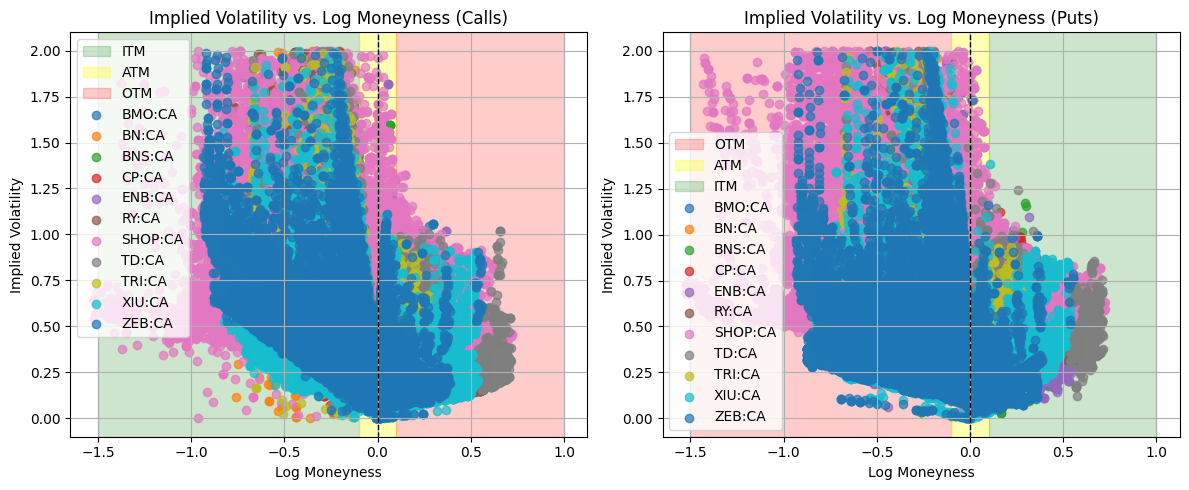

In [7]:
# Sample DataFrame structure
# df should have columns: 'underlying_symbol', 'underlying_price', 'strike', 'implied_volatility', 'option_type'

def plot_option_iv(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        if subplot_index == 1:
            plt.axvspan(-1.5, -0.1, color='green', alpha=0.2, label="ITM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='red', alpha=0.2, label="OTM")  # OTM region
        else:
            plt.axvspan(-1.5, -0.1, color='red', alpha=0.2, label="OTM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='green', alpha=0.2, label="ITM")  # OTM region

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Compute log moneyness
            stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

            # Scatter plot for each stock symbol
            plt.scatter(stock_data['log_moneyness'], stock_data['implied_volatility'], alpha=0.7, label=symbol)

        plt.xlabel("Log Moneyness")
        plt.ylabel("Implied Volatility")
        plt.title(f"Implied Volatility vs. Log Moneyness ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Vertical line at ATM
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_iv(df[(df["implied_volatility"] > 0) & (df["implied_volatility"] < 2)], df["underlying_symbol"].unique())


In [ ]:
# Cache for binomial tree vega calculations
binomial_cache = {}

def black_scholes_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def binomial_tree_price(S, K, T, r, sigma, option_type, steps=100):
    """ Compute American option price using binomial tree """
    key = (S, K, T, r, sigma, option_type, steps)
    if key in binomial_cache:
        return binomial_cache[key]

    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_price = np.zeros(steps + 1)
    option_value = np.zeros(steps + 1)

    for j in range(steps + 1):
        stock_price[j] = S * (u ** j) * (d ** (steps - j))
        option_value[j] = max(0, stock_price[j] - K) if option_type == 'call' else max(0, K - stock_price[j])

    for i in range(steps - 1, -1, -1):
        option_value[:i+1] = np.exp(-r * dt) * (p * option_value[1:i+2] + (1 - p) * option_value[:i+1])
        stock_price[:i+1] /= u  # Reverse tree
        if option_type == 'call':
            option_value[:i+1] = np.maximum(option_value[:i+1], stock_price[:i+1] - K)
        else:
            option_value[:i+1] = np.maximum(option_value[:i+1], K - stock_price[:i+1])

    binomial_cache[key] = option_value[0]
    return option_value[0]

def binomial_tree_vega(S, K, T, r, sigma, option_type, steps=100, epsilon=0.01):
    """ Compute Vega using finite differences on binomial tree pricing """
    price_up = binomial_tree_price(S, K, T, r, sigma + epsilon, option_type, steps)
    price_down = binomial_tree_price(S, K, T, r, sigma - epsilon, option_type, steps)
    return (price_up - price_down) / (2 * epsilon)

def compute_vega(df):
    df = df.copy()
    
    r = 0.02  # Assume a constant risk-free rate of 2%
    df['T'] = df['dte'] / 365  # Convert days to years
    
    # Vectorized Black-Scholes Vega
    valid_rows = df['T'] > 0
    df.loc[valid_rows, 'vega_bs'] = black_scholes_vega(
        df.loc[valid_rows, 'underlying_price'].values,
        df.loc[valid_rows, 'strike'].values,
        df.loc[valid_rows, 'T'].values,
        r,
        df.loc[valid_rows, 'implied_volatility'].values
    )

    # Parallelize Binomial Vega calculations
    unique_cases = df.loc[valid_rows, ['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type']].drop_duplicates()
    binomial_vegas = Parallel(n_jobs=-1)(
        delayed(binomial_tree_vega)(
            row['underlying_price'], row['strike'], row['T'], r, row['implied_volatility'], row['option_type']
        ) for _, row in unique_cases.iterrows()
    )

    unique_cases['vega_binomial'] = binomial_vegas

    # Merge back computed binomial vegas
    df = df.merge(unique_cases[['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type', 'vega_binomial']], 
                  on=['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type'], how='left')

    return df

# Apply Vega calculation
df = compute_vega(df)

# Display first few rows
df[['underlying_symbol', 'strike', 'implied_volatility', 'vega_bs', 'vega_binomial']].head()

In [12]:

# Cache for binomial tree vega calculations (moved inside the function)
def black_scholes_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def binomial_tree_price(S, K, T, r, sigma, option_type, steps=100):
    """ Compute American option price using binomial tree """
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_price = np.zeros(steps + 1)
    option_value = np.zeros(steps + 1)

    for j in range(steps + 1):
        stock_price[j] = S * (u ** j) * (d ** (steps - j))
        option_value[j] = max(0, stock_price[j] - K) if option_type == 'call' else max(0, K - stock_price[j])

    for i in range(steps - 1, -1, -1):
        option_value[:i+1] = np.exp(-r * dt) * (p * option_value[1:i+2] + (1 - p) * option_value[:i+1])
        stock_price[:i+1] /= u  # Reverse tree
        if option_type == 'call':
            option_value[:i+1] = np.maximum(option_value[:i+1], stock_price[:i+1] - K)
        else:
            option_value[:i+1] = np.maximum(option_value[:i+1], K - stock_price[:i+1])

    return option_value[0]

def binomial_tree_vega(S, K, T, r, sigma, option_type, steps=100, epsilon=0.05):  # Increased epsilon
    """ Compute Vega using finite differences on binomial tree pricing """
    price_up = binomial_tree_price(S, K, T, r, sigma + epsilon, option_type, steps)
    price_down = binomial_tree_price(S, K, T, r, sigma - epsilon, option_type, steps)
    return (price_up - price_down) / (2 * epsilon)

def compute_vega(df):
    df = df.copy()
    
    r = 0.02  # Assume a constant risk-free rate of 2%
    df['T'] = df['dte'] / 365  # Convert days to years
    
    # Vectorized Black-Scholes Vega
    valid_rows = df['T'] > 0

    # Parallelize Binomial Vega calculations (safely access unique rows)
    unique_cases = df.loc[valid_rows, ['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type']].drop_duplicates()
    
    # Parallel Vega Calculation (without global cache)
    binomial_vegas = Parallel(n_jobs=-1)(
        delayed(binomial_tree_vega)(row['underlying_price'], row['strike'], row['T'], r, row['implied_volatility'], row['option_type'])
        for _, row in unique_cases.iterrows()
    )

    unique_cases['vega_binomial'] = binomial_vegas

    # Merge back computed binomial vegas
    df = df.merge(unique_cases[['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type', 'vega_binomial']], 
                  on=['underlying_price', 'strike', 'T', 'implied_volatility', 'option_type'], how='left')

    return df

# Apply Vega calculation
df = compute_vega(df)

# Display first few rows
df[['underlying_symbol', 'strike', 'implied_volatility', 'vega_bs', 'vega_binomial']].head()


KeyError: "['vega_binomial'] not in index"

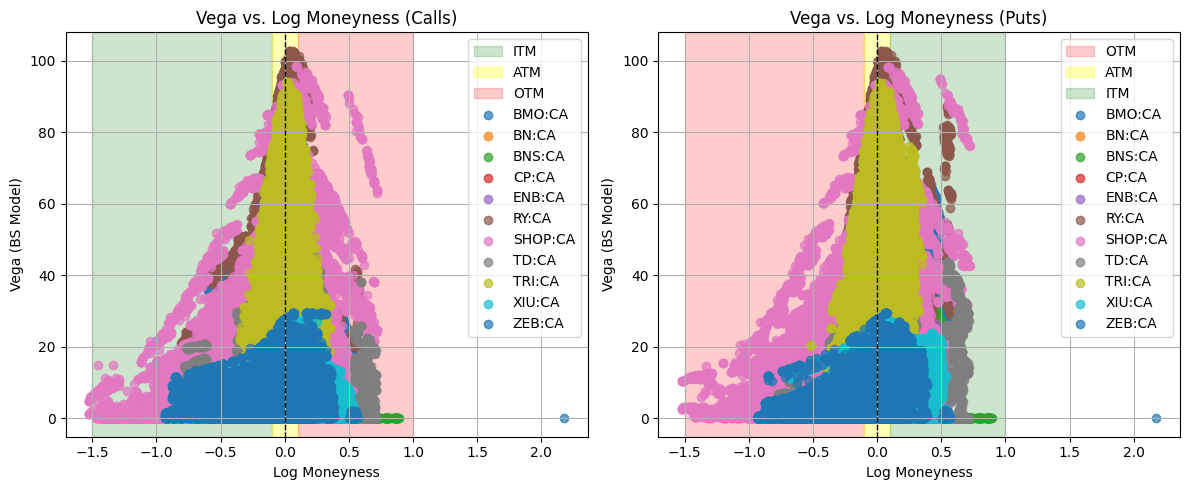

In [9]:
def plot_option_vega(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        if subplot_index == 1:
            plt.axvspan(-1.5, -0.1, color='green', alpha=0.2, label="ITM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='red', alpha=0.2, label="OTM")  # OTM region
        else:
            plt.axvspan(-1.5, -0.1, color='red', alpha=0.2, label="OTM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='green', alpha=0.2, label="ITM")  # OTM region

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Compute log moneyness
            stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

            # Scatter plot for each stock symbol using 'vega_bs' instead of 'implied_volatility'
            plt.scatter(stock_data['log_moneyness'], stock_data['vega_bs'], alpha=0.7, label=symbol)

        plt.xlabel("Log Moneyness")
        plt.ylabel("Vega (BS Model)")
        plt.title(f"Vega vs. Log Moneyness ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Vertical line at ATM
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_vega(df, df["underlying_symbol"].unique())


C:\Users\viraj\AppData\Local\Temp\ipykernel_240\964645639.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\viraj\OneDrive\Desktop\Apex Projects\apexenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


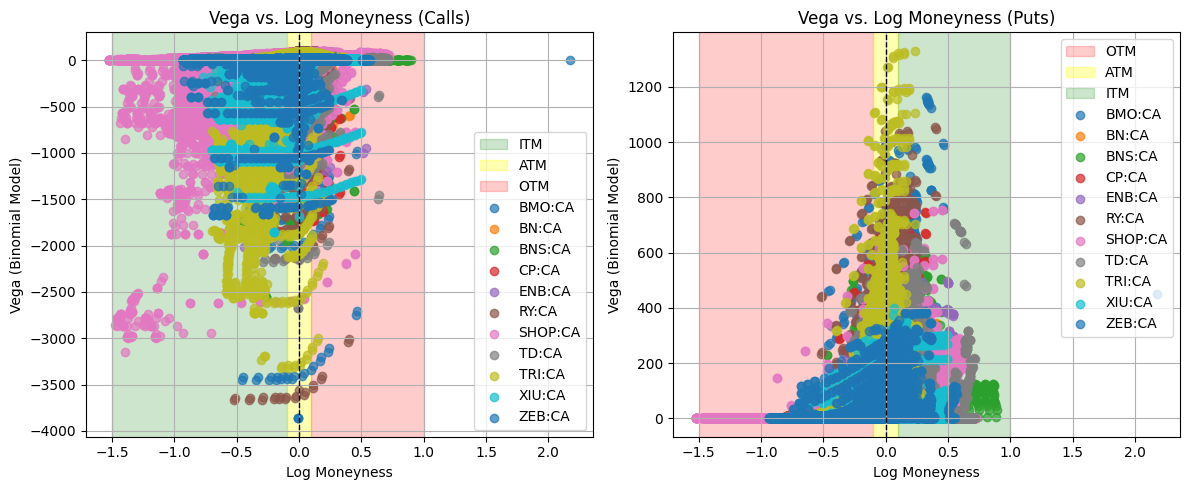

In [18]:
def plot_option_vega(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        if subplot_index == 1:
            plt.axvspan(-1.5, -0.1, color='green', alpha=0.2, label="ITM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='red', alpha=0.2, label="OTM")  # OTM region
        else:
            plt.axvspan(-1.5, -0.1, color='red', alpha=0.2, label="OTM")  # ITM region
            plt.axvspan(-0.1, 0.1, color='yellow', alpha=0.3, label="ATM")  # ATM region
            plt.axvspan(0.1, 1, color='green', alpha=0.2, label="ITM")  # OTM region

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Compute log moneyness
            stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

            # Scatter plot for each stock symbol using 'vega_bs' instead of 'implied_volatility'
            plt.scatter(stock_data['log_moneyness'], stock_data['vega_binomial_y'], alpha=0.7, label=symbol)

        plt.xlabel("Log Moneyness")
        plt.ylabel("Vega (Binomial Model)")
        plt.title(f"Vega vs. Log Moneyness ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Vertical line at ATM
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_vega(df[df["vega_binomial_y"] > -5000], df["underlying_symbol"].unique())


C:\Users\viraj\AppData\Local\Temp\ipykernel_240\3977402174.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


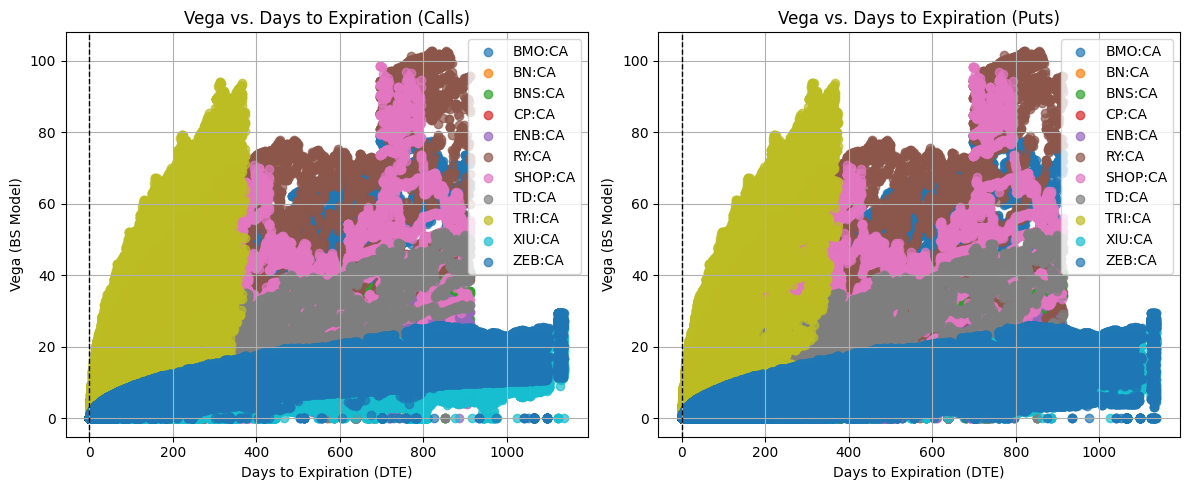

: 

In [ ]:
def plot_option_vega_by_dte(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        
        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Scatter plot for each stock symbol using 'dte' on x-axis and 'vega_binomial_y' on y-axis
            plt.scatter(stock_data['dte'], stock_data['vega_bs'], alpha=0.7, label=symbol)

        plt.xlabel("Days to Expiration (DTE)")
        plt.ylabel("Vega (BS Model)")
        plt.title(f"Vega vs. Days to Expiration ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Optional: Vertical line at 0 DTE
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_vega_by_dte(df, df["underlying_symbol"].unique())


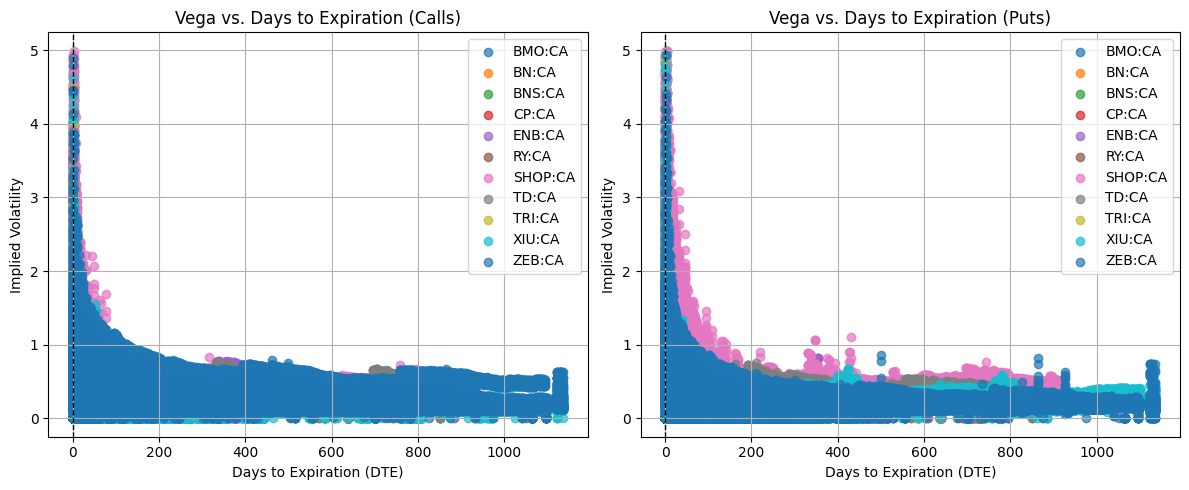

In [7]:
def plot_option_iv_by_dte(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)  # Two subplots side by side
        
        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Scatter plot for each stock symbol using 'dte' on x-axis and 'vega_binomial_y' on y-axis
            plt.scatter(stock_data['dte'], stock_data['implied_volatility'], alpha=0.7, label=symbol)

        plt.xlabel("Days to Expiration (DTE)")
        plt.ylabel("Implied Volatility")
        plt.title(f"Implied Volatility vs. Days to Expiration ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Optional: Vertical line at 0 DTE
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_iv_by_dte(df, df["underlying_symbol"].unique())


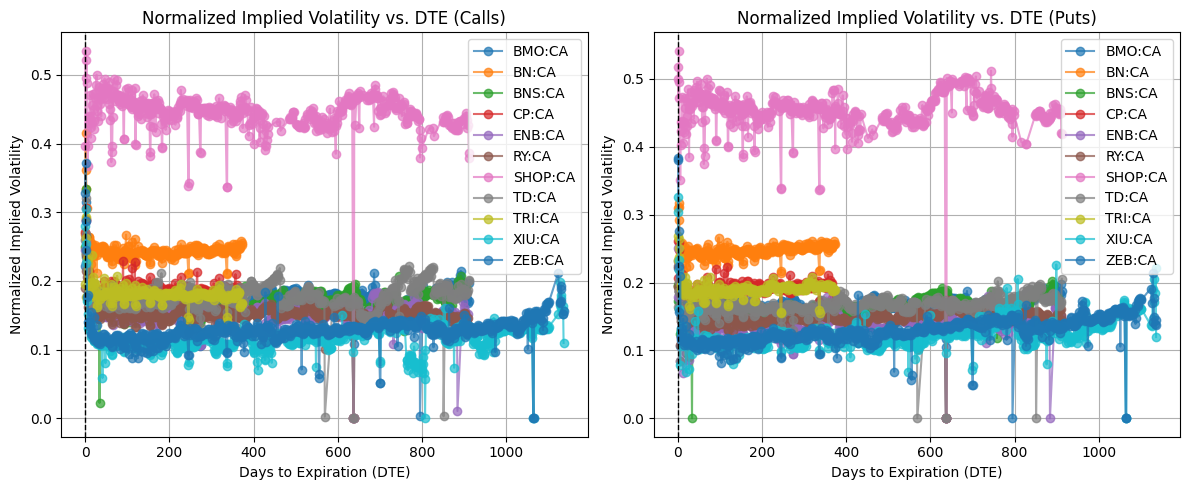

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_option_iv_by_dte(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)
        
        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
            
            # Calculate Moneyness (Strike Price / Stock Price)
            stock_data['moneyness'] = stock_data['strike'] / stock_data['underlying_price']
            
            # Filter Near-ATM Options
            filtered_data = stock_data[(stock_data['moneyness'] >= 0.95) & (stock_data['moneyness'] <= 1.05)]
            
            # Group by DTE and Average IV
            avg_iv = filtered_data.groupby('dte')['implied_volatility'].mean()
            
            # Plot Line Instead of Scatter
            plt.plot(avg_iv.index, avg_iv.values, marker='o', linestyle='-', alpha=0.7, label=symbol)

        plt.xlabel("Days to Expiration (DTE)")
        plt.ylabel("Normalized Implied Volatility")
        plt.title(f"Normalized Implied Volatility vs. DTE ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_iv_by_dte(df, df["underlying_symbol"].unique())


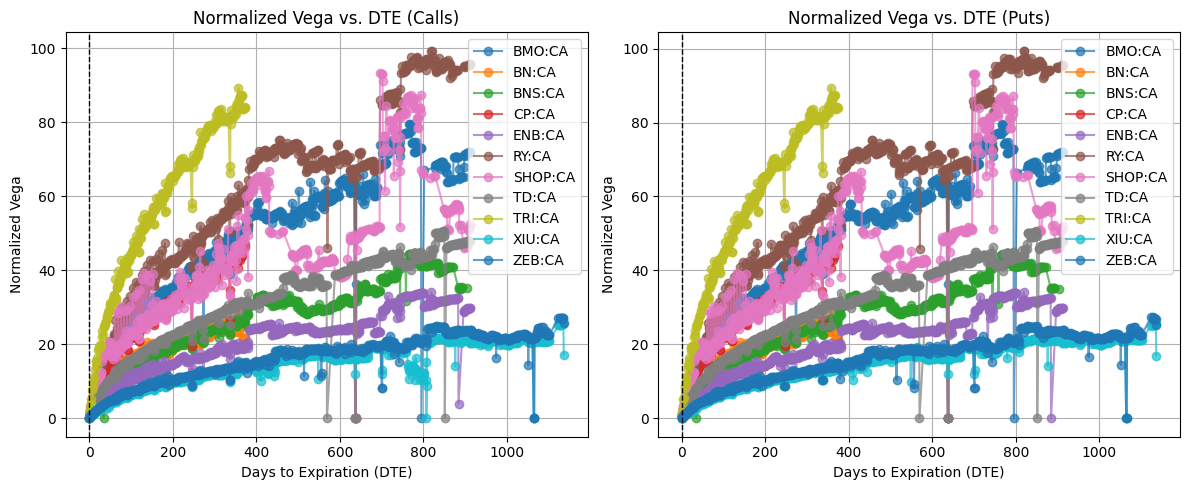

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_option_vega_by_dte(df, stock_symbols):
    plt.figure(figsize=(12, 5))

    for option_type, subplot_index, title in zip(['call', 'put'], [1, 2], ['Calls', 'Puts']):
        plt.subplot(1, 2, subplot_index)

        for symbol in stock_symbols:
            stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()

            # Calculate Moneyness
            stock_data['moneyness'] = stock_data['strike'] / stock_data['underlying_price']

            # Filter Near-ATM Options
            filtered_data = stock_data[(stock_data['moneyness'] >= 0.95) & (stock_data['moneyness'] <= 1.05)]

            # Group by DTE and Average Vega
            avg_vega = filtered_data.groupby('dte')['vega_bs'].mean()

            # Plot Line Instead of Scatter
            plt.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=symbol)

        plt.xlabel("Days to Expiration (DTE)")
        plt.ylabel("Normalized Vega")
        plt.title(f"Normalized Vega vs. DTE ({title})")
        plt.axvline(0, color='black', linestyle='--', linewidth=1)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_option_vega_by_dte(df, df["underlying_symbol"].unique())

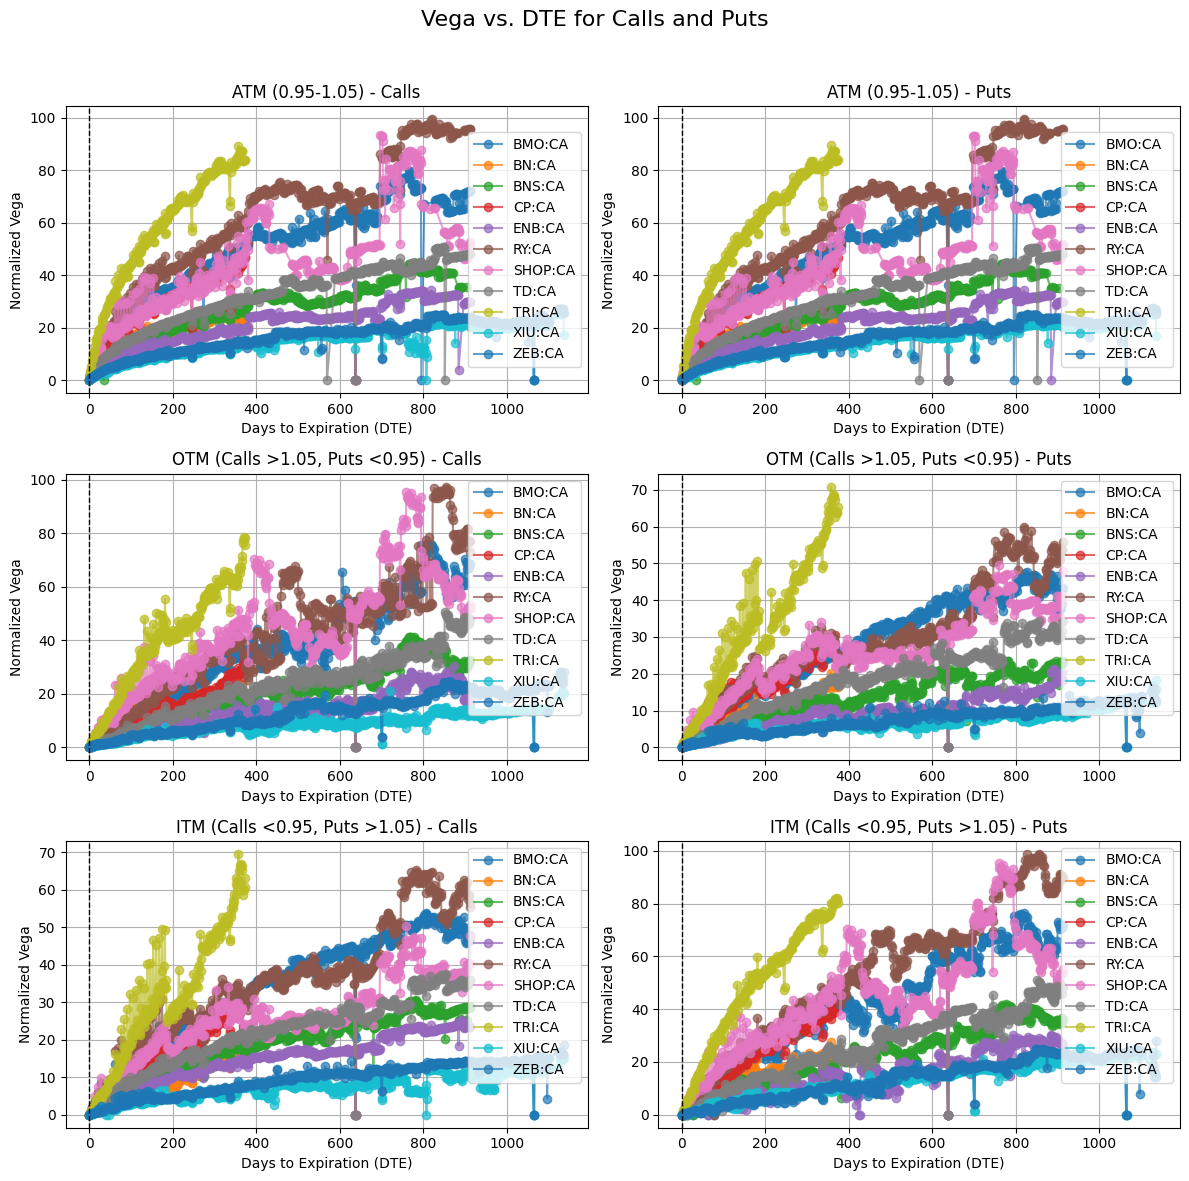

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_option_vega_by_dte(df, stock_symbols):
    categories = {
        "ATM (0.95-1.05)": (0.95, 1.05, 0.95, 1.05),
        "OTM (Calls >1.05, Puts <0.95)": (1.05, np.inf, -np.inf, 0.95),
        "ITM (Calls <0.95, Puts >1.05)": (-np.inf, 0.95, 1.05, np.inf),
    }

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns (Calls | Puts)
    fig.suptitle("Vega vs. DTE for Calls and Puts", fontsize=16)

    for row_idx, (category, (c_min, c_max, p_min, p_max)) in enumerate(categories.items()):
        for col_idx, option_type in enumerate(["call", "put"]):  # Calls on left, Puts on right
            ax = axes[row_idx, col_idx]

            for symbol in stock_symbols:
                stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
                
                # Compute Moneyness
                stock_data['moneyness'] = stock_data['strike'] / stock_data['underlying_price']

                # Apply Moneyness Filters
                if option_type == 'call':
                    filtered_data = stock_data[(stock_data['moneyness'] >= c_min) & (stock_data['moneyness'] <= c_max)]
                else:  # Put options
                    filtered_data = stock_data[(stock_data['moneyness'] >= p_min) & (stock_data['moneyness'] <= p_max)]

                # Group by DTE and Calculate Mean Vega
                avg_vega = filtered_data.groupby('dte')['vega_bs'].mean()

                # Plot Line for Each Stock Symbol
                ax.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=symbol)

            ax.set_xlabel("Days to Expiration (DTE)")
            ax.set_ylabel("Normalized Vega")
            ax.set_title(f"{category} - {'Calls' if option_type == 'call' else 'Puts'}")
            ax.axvline(0, color='black', linestyle='--', linewidth=1)
            ax.legend()
            ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Example usage
plot_option_vega_by_dte(df, df["underlying_symbol"].unique())


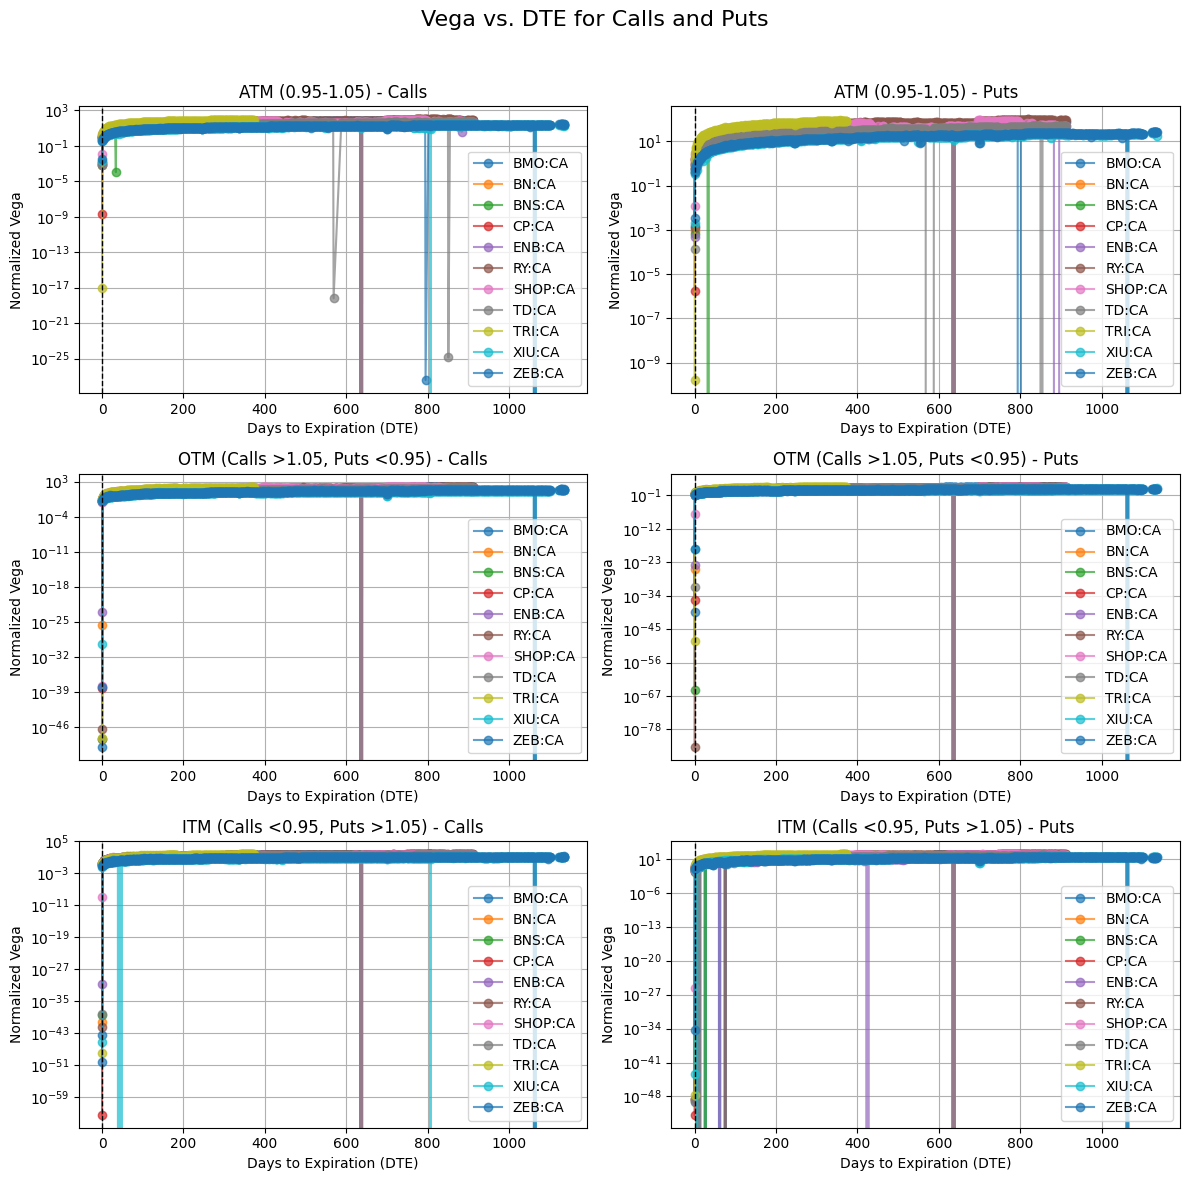

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_option_vega_by_dte(df, stock_symbols):
    categories = {
        "ATM (0.95-1.05)": (0.95, 1.05, 0.95, 1.05),
        "OTM (Calls >1.05, Puts <0.95)": (1.05, np.inf, -np.inf, 0.95),
        "ITM (Calls <0.95, Puts >1.05)": (-np.inf, 0.95, 1.05, np.inf),
    }

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns (Calls | Puts)
    fig.suptitle("Vega vs. DTE for Calls and Puts", fontsize=16)

    for row_idx, (category, (c_min, c_max, p_min, p_max)) in enumerate(categories.items()):
        for col_idx, option_type in enumerate(["call", "put"]):  # Calls on left, Puts on right
            ax = axes[row_idx, col_idx]

            for symbol in stock_symbols:
                stock_data = df[(df['underlying_symbol'] == symbol) & (df['option_type'] == option_type)].copy()
                
                # Compute Moneyness
                stock_data['moneyness'] = stock_data['strike'] / stock_data['underlying_price']

                # Apply Moneyness Filters
                if option_type == 'call':
                    filtered_data = stock_data[(stock_data['moneyness'] >= c_min) & (stock_data['moneyness'] <= c_max)]
                else:  # Put options
                    filtered_data = stock_data[(stock_data['moneyness'] >= p_min) & (stock_data['moneyness'] <= p_max)]

                # Group by DTE and Calculate Mean Vega
                avg_vega = filtered_data.groupby('dte')['vega_bs'].mean()

                # Plot Line for Each Stock Symbol
                ax.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=symbol)

            ax.set_xlabel("Days to Expiration (DTE)")
            ax.set_ylabel("Normalized Vega")
            ax.set_yscale('log')  # Apply log scale to Vega
            ax.set_title(f"{category} - {'Calls' if option_type == 'call' else 'Puts'}")
            ax.axvline(0, color='black', linestyle='--', linewidth=1)
            ax.legend()
            ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Example usage
plot_option_vega_by_dte(df, df["underlying_symbol"].unique())


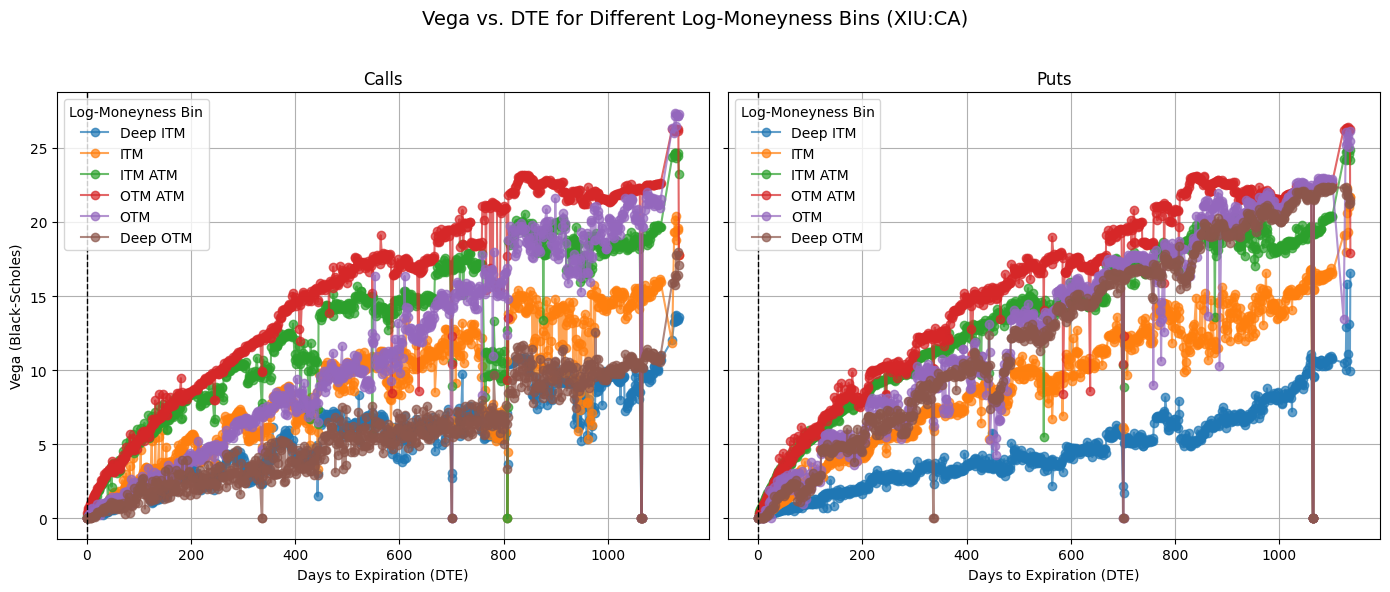

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_vega_by_dte_for_log_moneyness(df, symbol):
    # Filter for the given symbol and limit DTE
    stock_data = df[df['underlying_symbol'] == symbol].copy()

    # Compute Log Moneyness
    stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

    # Define Log Moneyness Bins
    bins = [-np.inf, -0.2, -0.1, 0, 0.1, 0.2, np.inf]
    bin_labels = ["Deep ITM", "ITM", "ITM ATM", "OTM ATM", "OTM", "Deep OTM"]
    stock_data["log_moneyness_bin"] = pd.cut(stock_data["log_moneyness"], bins, labels=bin_labels)

    # Create subplots: (1, 2) layout for Calls and Puts
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle(f"Vega vs. DTE for Different Log-Moneyness Bins ({symbol})", fontsize=14)

    for col_idx, option_type in enumerate(["call", "put"]):
        ax = axes[col_idx]

        for bin_label in bin_labels:
            bin_data = stock_data[(stock_data["log_moneyness_bin"] == bin_label) & (stock_data["option_type"] == option_type)]
            
            if not bin_data.empty:
                avg_vega = bin_data.groupby("dte")["vega_bs"].mean()
                ax.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=bin_label)

        ax.set_xlabel("Days to Expiration (DTE)")
        ax.set_title(f"{'Calls' if option_type == 'call' else 'Puts'}")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.legend(title="Log-Moneyness Bin")
        ax.grid(True)

    axes[0].set_ylabel("Vega (Black-Scholes)")  # Only left plot needs the y-axis label
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Example usage
plot_vega_by_dte_for_log_moneyness(df, "XIU:CA")


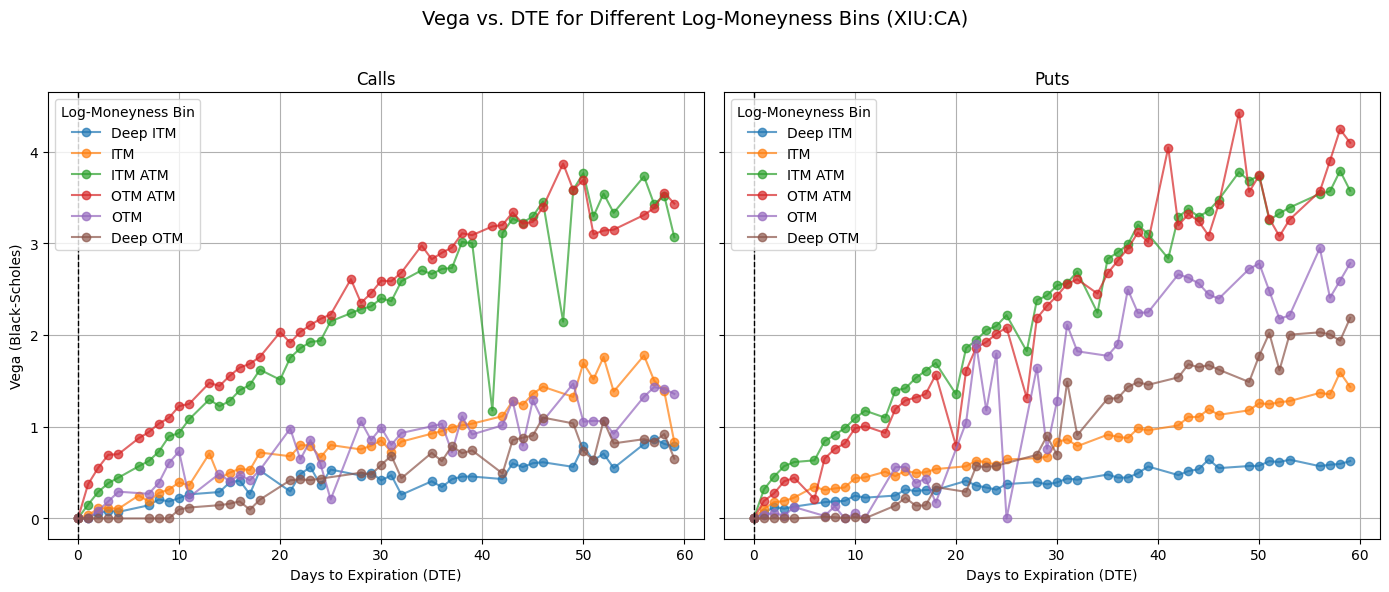

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_vega_by_dte_for_log_moneyness(df, symbol):
    # Filter for the given symbol and limit DTE
    stock_data = df[(df['underlying_symbol'] == symbol) & (df["dte"] <= 60)].copy()

    # Compute Log Moneyness
    stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

    # Define Log Moneyness Bins
    bins = [-np.inf, -0.2, -0.1, 0, 0.1, 0.2, np.inf]
    bin_labels = ["Deep ITM", "ITM", "ITM ATM", "OTM ATM", "OTM", "Deep OTM"]
    stock_data["log_moneyness_bin"] = pd.cut(stock_data["log_moneyness"], bins, labels=bin_labels)

    # Create subplots: (1, 2) layout for Calls and Puts
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle(f"Vega vs. DTE for Different Log-Moneyness Bins ({symbol})", fontsize=14)

    for col_idx, option_type in enumerate(["call", "put"]):
        ax = axes[col_idx]

        for bin_label in bin_labels:
            bin_data = stock_data[(stock_data["log_moneyness_bin"] == bin_label) & (stock_data["option_type"] == option_type)]
            
            if not bin_data.empty:
                avg_vega = bin_data.groupby("dte")["vega_bs"].mean()
                ax.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=bin_label)

        ax.set_xlabel("Days to Expiration (DTE)")
        ax.set_title(f"{'Calls' if option_type == 'call' else 'Puts'}")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.legend(title="Log-Moneyness Bin")
        ax.grid(True)

    axes[0].set_ylabel("Vega (Black-Scholes)")  # Only left plot needs the y-axis label
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Example usage
plot_vega_by_dte_for_log_moneyness(df, "XIU:CA")


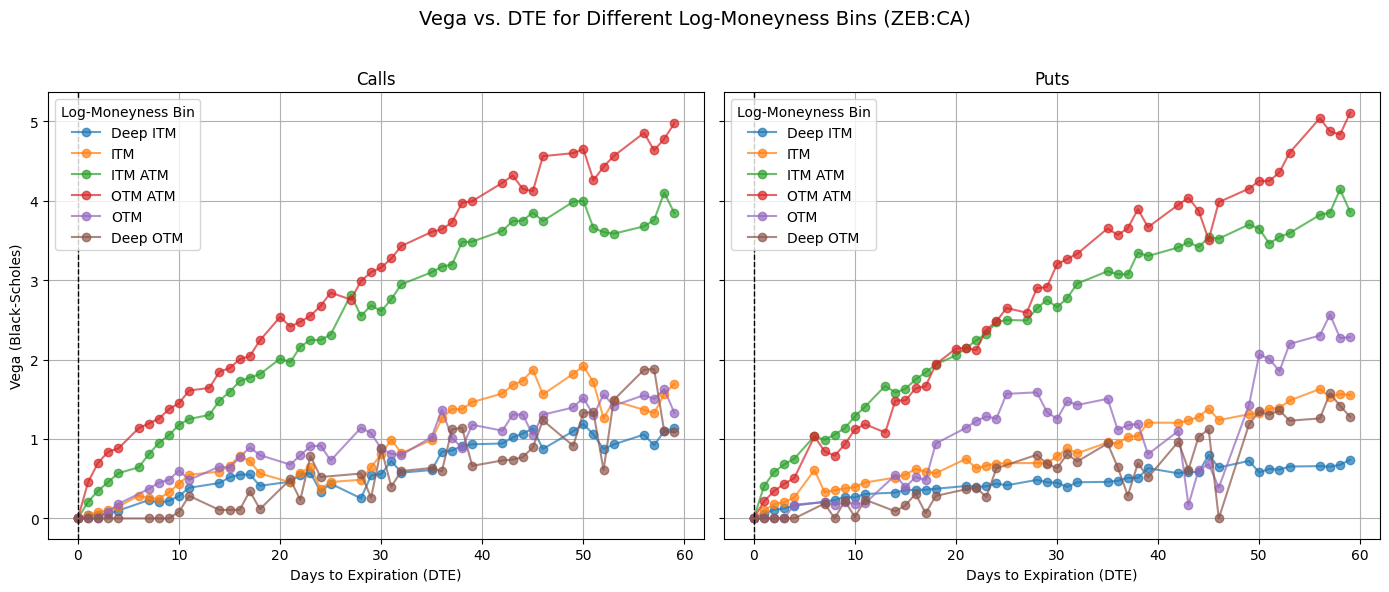

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_vega_by_dte_for_log_moneyness(df, symbol):
    # Filter for the given symbol and limit DTE
    stock_data = df[(df['underlying_symbol'] == symbol) & (df["dte"] <= 60)].copy()

    # Compute Log Moneyness
    stock_data['log_moneyness'] = np.log(stock_data['strike'] / stock_data['underlying_price'])

    # Define Log Moneyness Bins
    bins = [-np.inf, -0.2, -0.1, 0, 0.1, 0.2, np.inf]
    bin_labels = ["Deep ITM", "ITM", "ITM ATM", "OTM ATM", "OTM", "Deep OTM"]
    stock_data["log_moneyness_bin"] = pd.cut(stock_data["log_moneyness"], bins, labels=bin_labels)

    # Create subplots: (1, 2) layout for Calls and Puts
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle(f"Vega vs. DTE for Different Log-Moneyness Bins ({symbol})", fontsize=14)

    for col_idx, option_type in enumerate(["call", "put"]):
        ax = axes[col_idx]

        for bin_label in bin_labels:
            bin_data = stock_data[(stock_data["log_moneyness_bin"] == bin_label) & (stock_data["option_type"] == option_type)]
            
            if not bin_data.empty:
                avg_vega = bin_data.groupby("dte")["vega_bs"].mean()
                ax.plot(avg_vega.index, avg_vega.values, marker='o', linestyle='-', alpha=0.7, label=bin_label)

        ax.set_xlabel("Days to Expiration (DTE)")
        ax.set_title(f"{'Calls' if option_type == 'call' else 'Puts'}")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.legend(title="Log-Moneyness Bin")
        ax.grid(True)

    axes[0].set_ylabel("Vega (Black-Scholes)")  # Only left plot needs the y-axis label
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Example usage
plot_vega_by_dte_for_log_moneyness(df, "ZEB:CA")
